Dans cette partie, nous allons chercher à modéliser le cours des actions d'Apple au cours du temps,
avec dans un modèle sans machine learning, un modèle dit des "moyennes mouvantes" ou "Moving Average" en anglais.

0 - Préparatifs

Importation des biblothèques nécéssaires

In [1]:
import matplotlib.pyplot as plt # Pour les graphiques
import numpy as np
import yfinance as yf # Pour extraire les données de yahoo finance
import pandas as pd # Pour manipuler des data frames
import datetime

/Users/antoine/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Création du "Ticker" pour Apple, nécéssaire pour extraire les données sur Yahoo Finance

In [2]:
APL = "AAPL"

I - Récupération des données 

In [3]:
data = yf.Ticker(APL) # Extraction avec la fonction yf.Ticker de yfinance
prix_rec = data.history(period = '1d', start = '2020-1-1', end = '2023-10-26') # On choisit une date de fin arbitraire
prix_anc = data.history(period = '1d', start = '1980-12-12', end = '2023-10-26') 

AAPL: No price data found, symbol may be delisted (1d 2020-1-1 -> 2023-10-26)
AAPL: No price data found, symbol may be delisted (1d 1980-12-12 -> 2023-10-26)


On choisit une date de fin de récupération des données arbitraire. L'objectif est que notre modèle, qui va chercher à prédire le futur, en considérant le futur comme les dates après la fin de son échantillon d'entraienement, puisse être comparé avec les valeurs réelles que l'on pourra récupérer plus tard.

D'autre part, on va utiliser des data frames Panda qui sont plus manipulables que l'objet "data" récuperé avec yf.Ticker
Pour ce faire, on peut directement transformer le CSV mis à disposition par le site et le transformer en data frame.

In [4]:
df=pd.read_csv("AAPL.csv")  # Passage en pandas 

Il y a tout de même un léger nettoyage à faire, on ne conserve que les dates qui nous intéressent, pour ce faire on doit s'assurer que les dates sont bien en format date.

In [5]:
df['Date']=pd.to_datetime(df['Date']) # On convertit en amont toutes les dates en dates
df = df[df['Date'] >= pd.to_datetime('2020-01-01')] # Puis on ne garde qu'à partir de 2020

I - Premières visualisations descriptives de la base de données

I.1 - Prix de l'action à la fermeture du marché

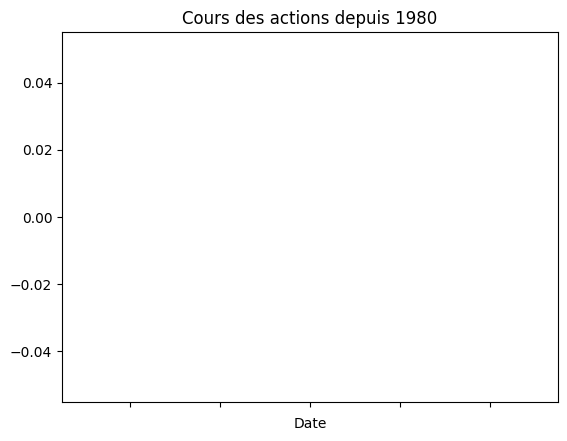

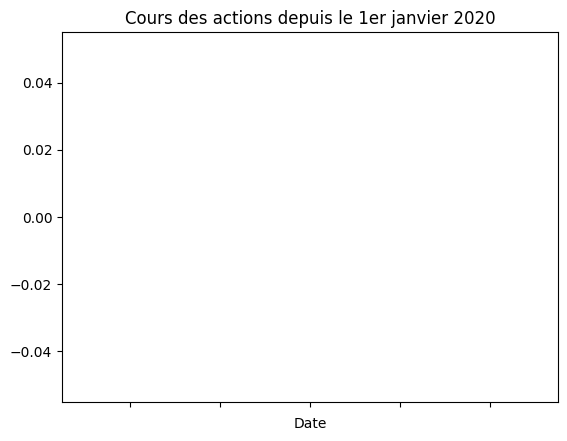

In [6]:
plt.title('Cours des actions depuis 1980')
prix_anc['Close'].plot() # Depuis 1980
plt.show()

plt.title('Cours des actions depuis le 1er janvier 2020')
prix_rec['Close'].plot() # Depuis 2020
plt.show()



On définit cette fonction qui va nous permettre d'afficher nos séries temporelles de manière plus facile en jouant sur tous les paramètres en entrée.

In [7]:
def plot_series(time, series, format="-", start=0, end=None, label=None): 
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


On définit des grandeurs qui vont nous servir plus tard, pour zoomer sur certaines parties par exemple

In [8]:
time = np.arange(962)  # Intervalle de temps : tous les jours depuis le 2020-01-01

split_time = 500       # Temps à partir duquel on concentre notre étude

time_valid = time[split_time:] # Temps de validation du modèle 
x_valid = df['Close'][split_time:] # Partie de la courbe qui nous intéresse 

On a changé la division du temps, on associe, pour plus de facilité dans la manipulation, chaque date à un entier entre 0 et 962 ce qui correspond au nombre de jours dans notre intervalle d'étude à savoir depuis le 01/01/2020.

I-2 - Comparaison des valeurs de fermeture et d'ouverture

On cherche ici à voir si on peut observer des différences majeures lors de certains jours
On se concentre ici sur l'intervalle le plus récent de l'étude, à partir de 500

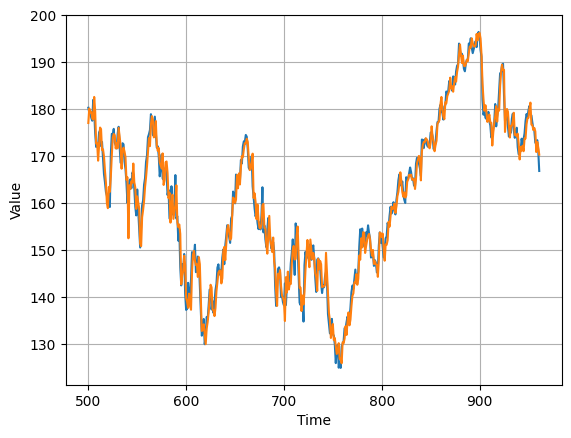

In [9]:
x_ouverture = df['Open'][split_time:] # l'analogue de x_valid avec 'Open' à la place de 'Close'

plot_series(time_valid, x_valid)
plot_series(time_valid, x_ouverture)
plt.show()


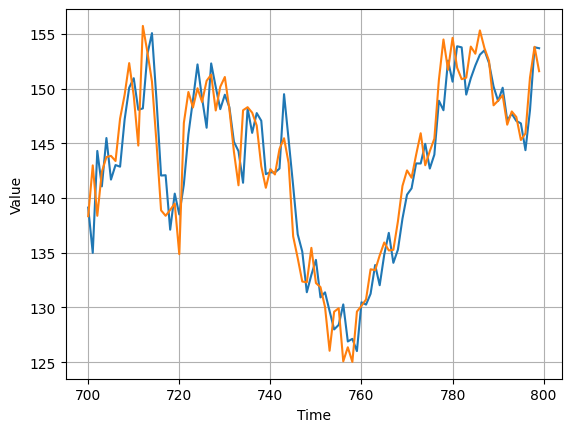

In [10]:
# On peut encore plus zoomer sur des intervalles de temps précis pour percevoir des différences certains jours

plot_series(time[700:800], df['Open'][700:800])
plot_series(time[700:800], df['Close'][700:800])
plt.show()

I-3 - Comparaison des valeurs hautes et des valeurs faibles

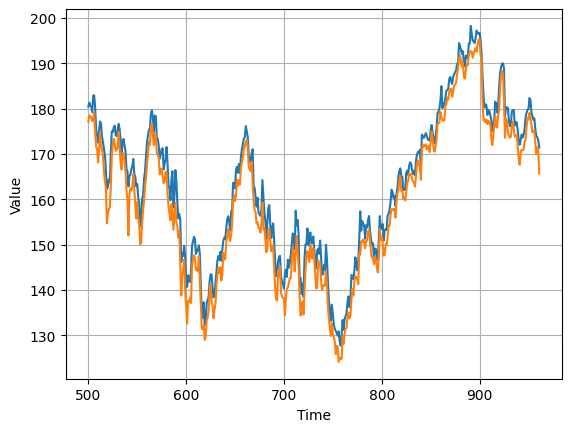

In [11]:
plot_series(time[split_time:], df['High'][split_time:])
plot_series(time[split_time:], df['Low'][split_time:])
plt.show()

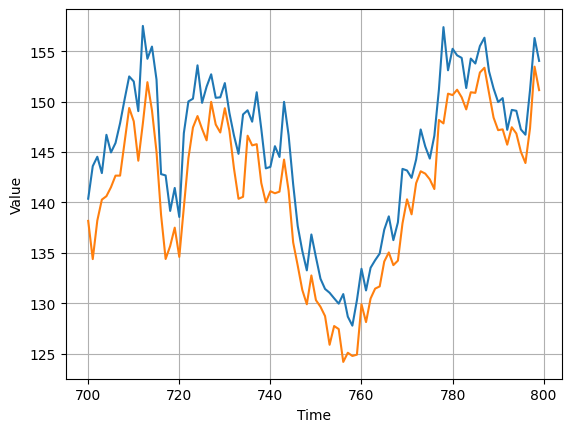

In [12]:
# En zoomant sur un passage intéressant

plot_series(time[700:800], df['High'][700:800])
plot_series(time[700:800], df['Low'][700:800])
plt.show()

I-4 - Volume de transaction chaque jour

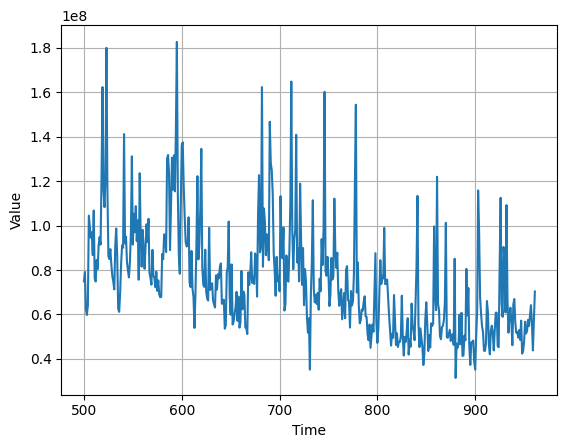

In [13]:
plot_series(time[split_time:], df['Volume'][split_time:])

II - Modélisation avec la méthode du "Moving Average"

In [14]:
df = df[['Date', 'Close']] # On ne garde que la variable de close qui est celle qui nous intéresse pour aller plus vite dans l'éxecution

df['NumeroLigne'] = df.reset_index().index # Pour indexer le temps, ce qui va nous servir dans le futur

On rappelle le cours de l'action à partir de la date '500'

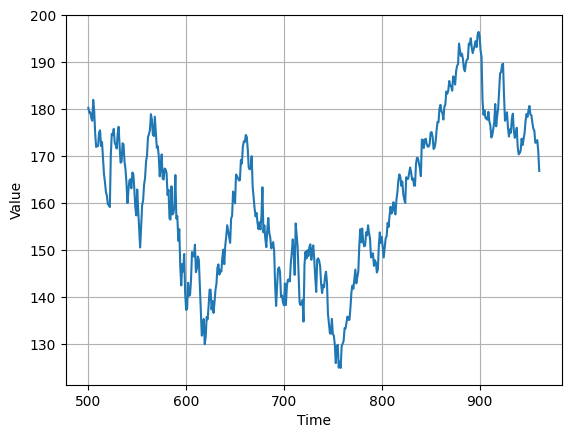

In [15]:
plot_series(time_valid, x_valid) # Visualisation du cours de l'action Apple plus récemment

On peut implémenter notre modèle en un seul code.
Le principe du 'Moving Average' est que chaque valeur prédite par notre modèle est la moyenne des x précédentes valeurs où x est un paramètre à choisir.
Ce modèle permet une bonne prédiction mais surtout de lisser la courbe et son bruit.
Néanmoins l'erreur est supposée être assez importante comparé à des modèles plus developpés

In [16]:
def forecast_moyenne(series, window_size): # Implementation
  """La prochaine valeur est la moyenne des 'window_size' dernières valeurs"""

  forecast = [] # Crée une liste vide appelée forecast pour stocker les prévisions

  for time in range(len(series) - window_size): # On coupe à len(series) - window_size parce que sinon il n'y a plus assez de valeurs
                                                # Pour moyenner les window_size précédentes valeurs

    forecast.append(series[time:time + window_size].mean()) # Ajoute à la liste forecast la moyenne des valeurs sur l'intervalle de taille window size

  return np.array(forecast) # Convertit la liste forecast en un tableau numpy et le renvoie
                            # Ainsi on pourra l'exploiter par la suite

On crée alors notre tableau avec les valeurs modélisées par notre modèle

In [17]:
prix_forecast = forecast_moyenne(df['Close'], 30)[split_time - 30:] # Prédiction de la valeur du prix

# On commence en avance par rapport au temps qui nous intéresse pour pouvoir avoir 'window_size' de temps déja connus
# Ainsi on pourra faire la moyenne des 'window_size' (ici 30) précédentes valeurs pour que à partir de 'split_time'
# les valeurs soient uniquement des valeurs crées par notre modèle 

Première visualisation du résultat obtenu.

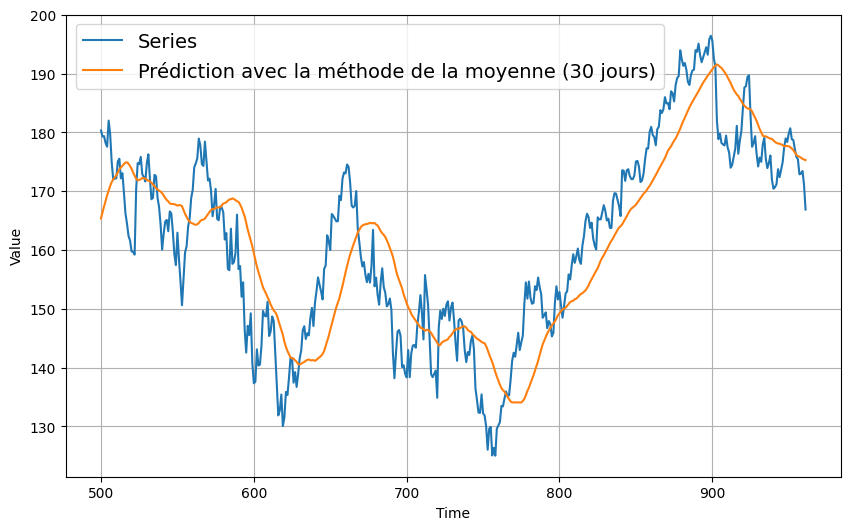

In [18]:
plt.figure(figsize=(10, 6)) # On compare 
plot_series(time_valid, x_valid, label = "Series")
plot_series(time_valid, prix_forecast, label = "Prédiction avec la méthode de la moyenne (30 jours)")

Le résultat est assez satisfaisant, on obtient une belle courbe qui capte bien les variations du cours de l'action.

Essayons de faire varier la fenêtre pour obtenir un modèle plus précis.

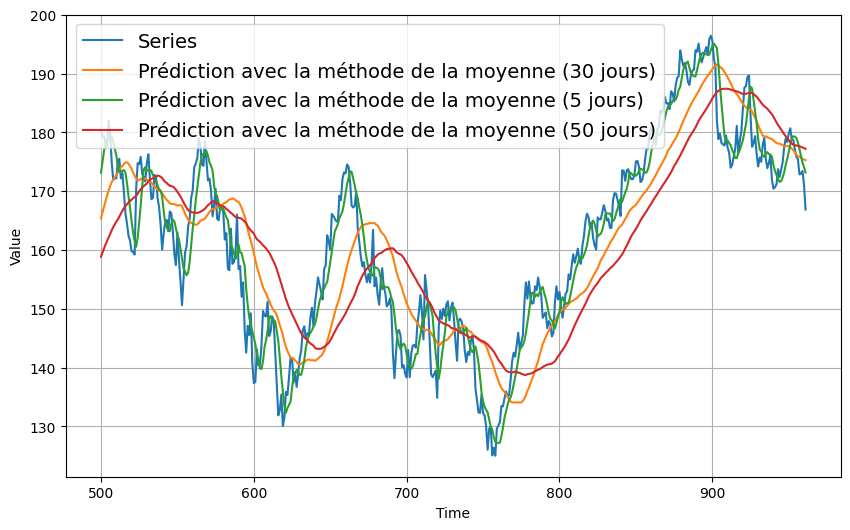

In [19]:
prix_forecast5 = forecast_moyenne(df['Close'], 5)[split_time - 5:]
prix_forecast50 = forecast_moyenne(df['Close'], 50)[split_time - 50:]

plt.figure(figsize=(10, 6)) # On compare 
plot_series(time_valid, x_valid, label = "Series")
plot_series(time_valid, prix_forecast, label = "Prédiction avec la méthode de la moyenne (30 jours)")
plot_series(time_valid, prix_forecast5, label = "Prédiction avec la méthode de la moyenne (5 jours)")
plot_series(time_valid, prix_forecast50, label = "Prédiction avec la méthode de la moyenne (50 jours)")

On comprend dans ce cas précis que le moins on prend de valeurs dans la fenêtre dont on fait la moyenne, et le plus sera précise notre prédiction.

Après avoir remarqué cela, on s'attaque ici dans un second temps à un second modèle sans machine learning.
Il s'agit du modèle de prévision naive où 'Naive Forecast' en anglais.
Le concept du modèle est que chaque valeur de notre modèle est la valeur à la date précédente de la courbe de base. On peut considérer cela comme un modèle de Moving Average avec une window size égale à 1.

Le modèle est donc très efficace pour les modèles qui ne sont pas soumis à d'énormes variations.

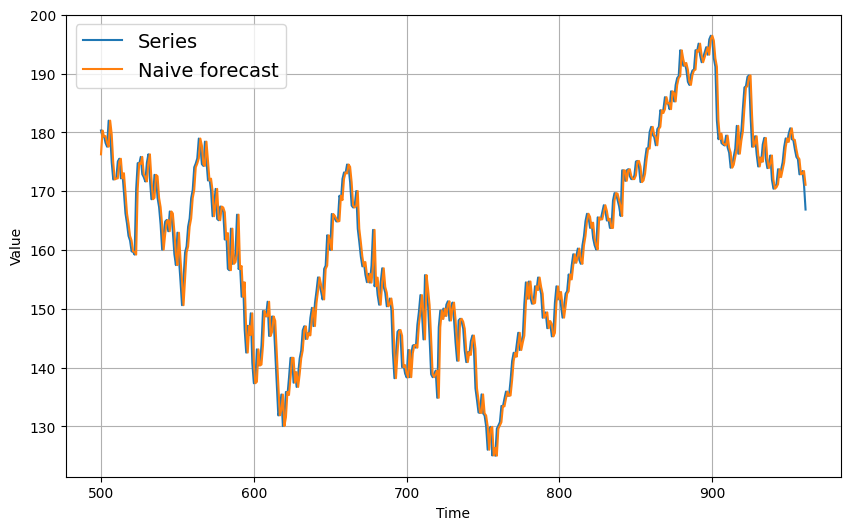

In [20]:
naive_forecast = df['Close'][split_time - 1:-1] # Avec le naive forecast

# Le naive forecast consiste à prédire chaque valeur par la valeur précedente du modèle
# Ici on commence donc à la valeur qui précède l'intervalle qui nous intéresse jusqu'à la fin

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, naive_forecast, label= "Naive forecast")

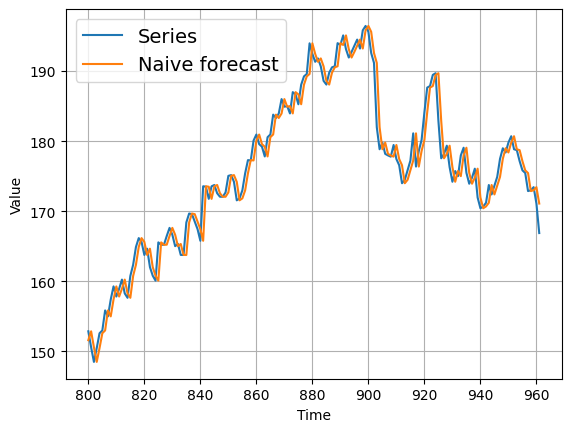

In [21]:
# On zoom sur l'efficacité du naive forecast 

split_time2 = 800
time_naive = time[split_time2:]
x_naive = df['Close'][split_time2:]
naive_forecast2 = df['Close'][split_time2 - 1:-1]
plot_series(time_naive, x_naive, label="Series")
plot_series(time_naive, naive_forecast2, label="Naive forecast")

Superposons les deux modèles avant de comparer leurs erreurs respectives

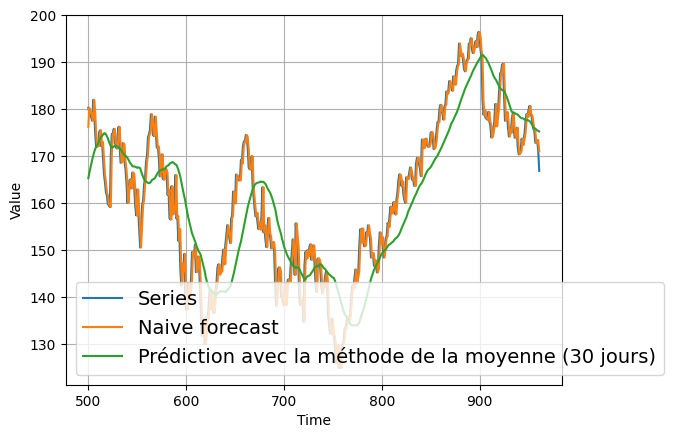

In [22]:
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, naive_forecast, label= "Naive forecast")
plot_series(time_valid, prix_forecast, label = "Prédiction avec la méthode de la moyenne (30 jours)")

Comparaison des erreurs des modèles

In [23]:
# Erreur des modèles 
import tensorflow as tf 

# Naive forecast 
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()) # On utilise le module d'erreurs de la librairie tensorflow
# Mean Absolute Error : différence moyenne absolue

# Forecast moyen 
print(tf.keras.metrics.mean_absolute_error(x_valid, prix_forecast).numpy())

2.2220128095238088
7.309727871789324


Le modèle de naive forecast est très efficace ici, tandis que l'erreur du modèle de moving average est assez importante. 
On peut tout de même essayer d'aller plus loin à l'aide d'un modèle faisant appel a du machine learning !